In [1]:
import random
import math
import matplotlib.pyplot as plt
from IPython.display import Image

### CIGRE microgrid standard version

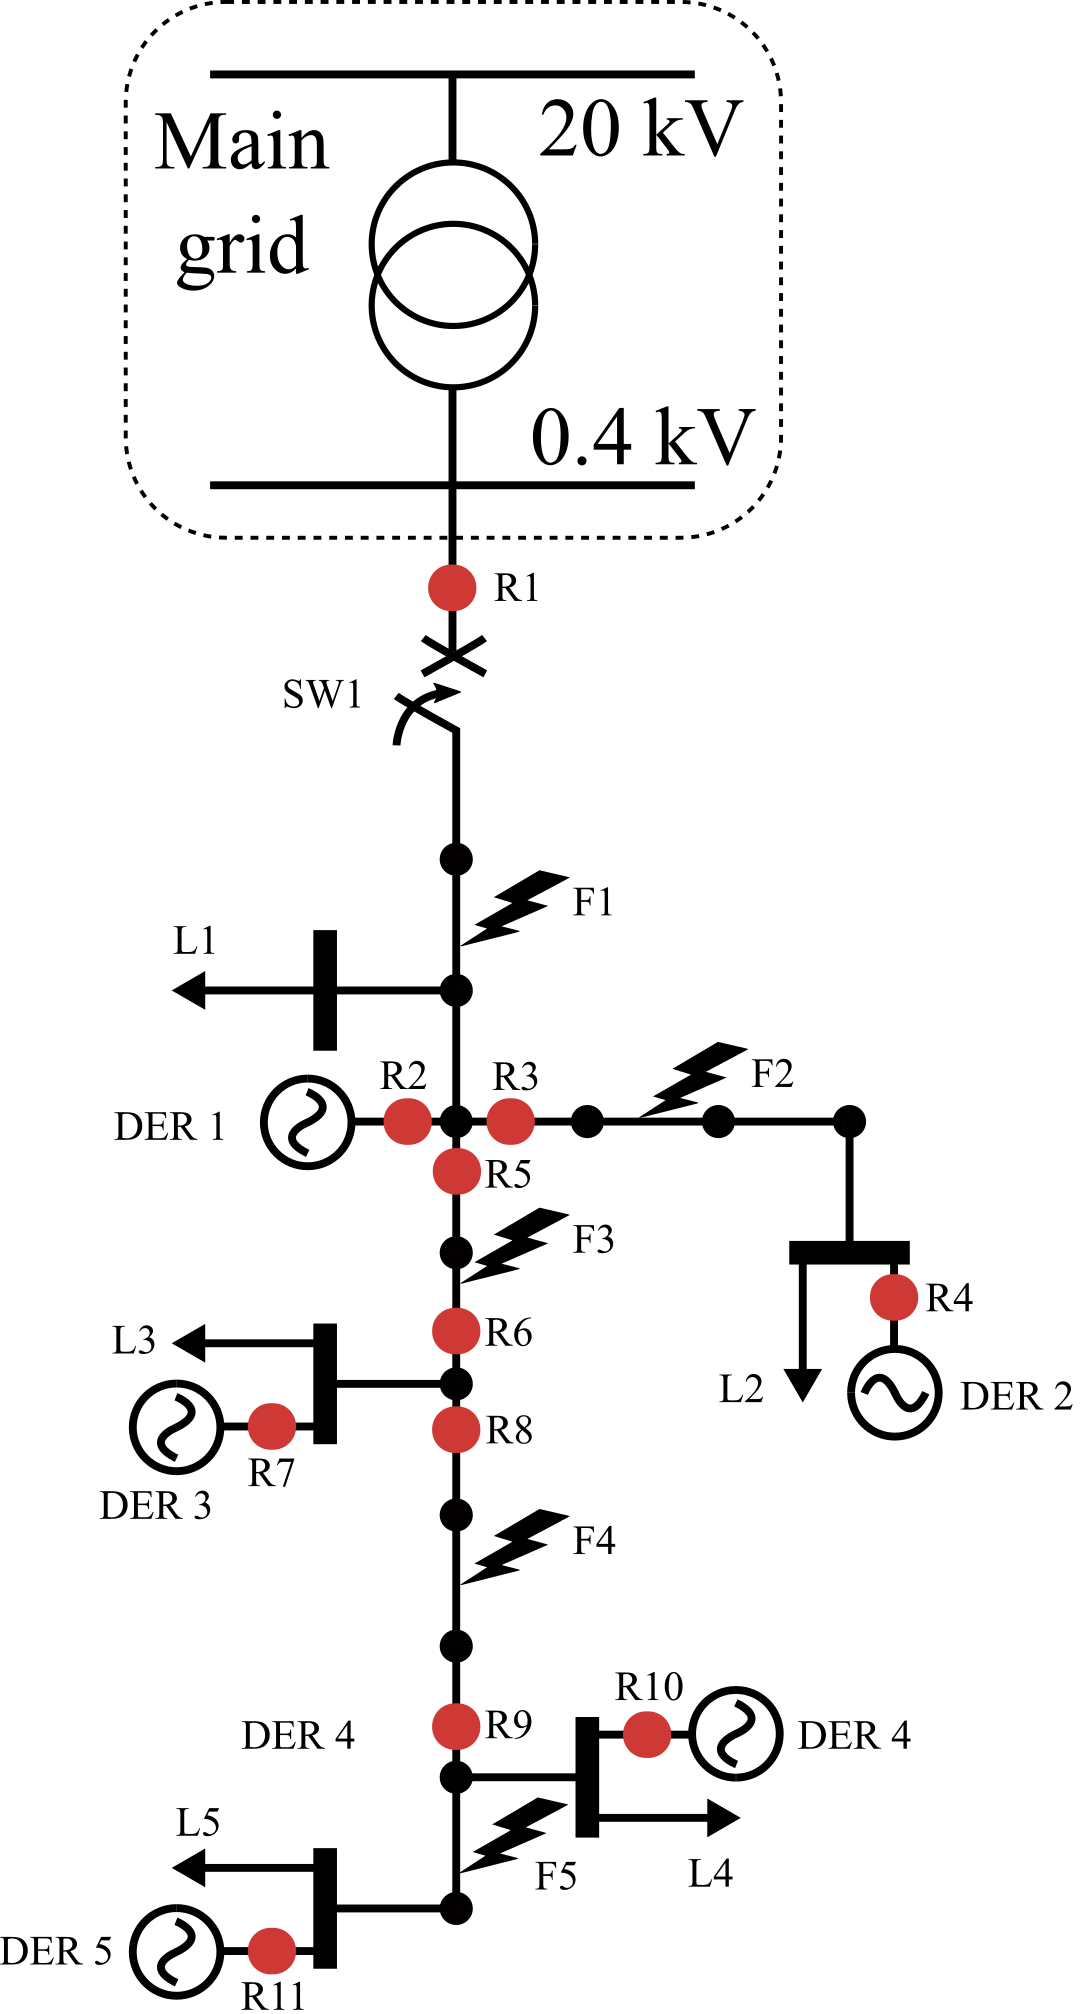

In [3]:
Image(filename = "cigre_microgrid.png", width = 400, height = 100)

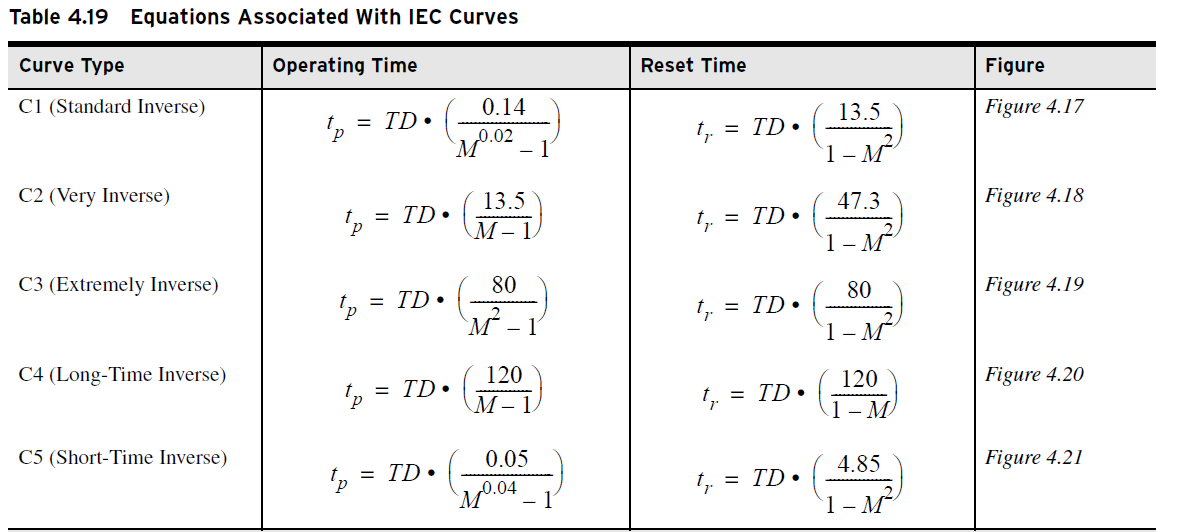

In [13]:
Image(filename = "curves_iec.png", width = 800, height = 200)

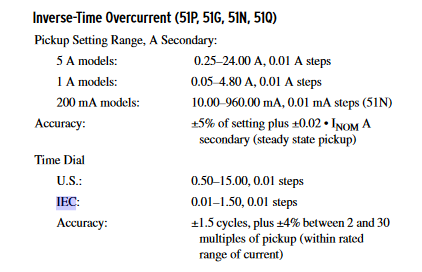

In [5]:
Image(filename = "SEL751_CONS.png", width = 400, height = 100)

### Generating the objective function

Nomenclature: 

$ t_p :$ operation time primary relay 

$ t_b :$ operation time back-up relay

$ PSM :$ plug setting multiplier

$ PS :$ plug setting

$ TDS :$ Time multiplier setting

$ CTI :$ Coordination time interval

$ I_{fault}:$ Fault current

$ I_{fmin}:$ Minimum Fault current

$ I_{load}:$ Load current

$ I_{pu}:$ Pick up current

$ CTR :$ Current transformer ratio

The objective function is to minimize the operating times of the primary and back up relays as:

$$min~ f(I_{pu},TDS) = min~ \sum_{i=1}^n (t_p +t_b)$$

where  $$ t_p,t_b = f(TDS,PSM)$$

All relays assumed to be identical and to have normal IDMT characteristics as:

$$ t_{p,b} = \frac{\alpha \times TDS}{PSM^\beta - 1} $$

where

$$ PSM = \frac{I_{fault}}{I_{pu}} $$

$$ I_{pu} = CTR \times PS $$

$\alpha$ and $\beta$ values depending on the type of IDMT relay

| IDMT type | $\alpha$ | $\beta$ |
| --- | --- | --- |
| Standard Inverse | 0.14 | 0.02 |
| Very Inverse | 13.5 | 1 |
| Extreme Inverse | 80 | 2 |



Settings constraints for each relay are given as 

$$0.025 s < TDS < 1.2 s$$ with steps of 0.01s according to [1] Adelnia, F., Moravej, Z., Farzinfar, M.: ‘A new formulation for
coordination of directional overcurrent relays in interconnected
networks’, Int. Trans. Electr.Energy Syst., 2015, 25, (1), pp. 120–137

$$t_b - t_p \geq CTI \approx 300ms$$

Also, $t_p, t_b$ can have a minimum operating time depending on the needs and can variate for example from:

$$ t_{p},t_{b} > t_{pmin},t_{bmin} \approx 50-100 ms$$

And pick up current of

$$ 1.3 \times I_{load}-2\times I_{load} < I_{pu}< I_{fmin} $$ 

or following the thumb rule $$ I_{pu} = \frac{2}{3} \times I_{fmin} $$ 

$I_{fault}$ and $I_{load}$ can be found by simulation, in this algorithm, we used simulation results from SIMULINK on the network LV CIGRE benchmark seen in the figure above

#### Finally

Finally the optimization function can be represented as:

 $$ min~ f(PS,TDS) = \frac{0.14 \times TDS_{p1}}{(\frac{I_{fault-p1}}{CTR \times PS_{p1}})^{0.02} - 1} + \frac{0.14 \times TDS_{b1}}{(\frac{I_{fault-b1}}{CTR \times PS_{b1}})^{0.02} - 1} + ...$$ 

$$ $$

#### Operating constrains

$$ \frac{0.14 \times TDS_{p1}}{(\frac{I_{fault-p1}}{CTR \times PS_{p1}})^{0.02} - 1}- \frac{0.14 \times TDS_{b1}}{(\frac{I_{fault-b1}}{CTR \times PS_{b1}})^{0.02} - 1} +0.3 \leq 0 $$

$$ ... $$

#### Minimum operating constrain

$$ \frac{0.14 \times TDS_{p1}}{(\frac{I_{fault-p1}}{CTR \times PS_{p1}})^{0.02} - 1}+ 0.1 \leq 0 $$

$$ \frac{0.14 \times TDS_{b1}}{(\frac{I_{fault-b1}}{CTR \times PS_{b1}})^{0.02} - 1} +0.1 \leq 0 $$

$$...$$

## Algorithm 

In this step we aim to optimize the function for $PS_{Ri}$ and $TDS_{Ri}$

TDS_R1 = Time dial setting Relay 1 and so on.... 

PS_R1  = Plug setting Relay 1 and so on....

If_R1_P1 = Fault current seen by relay 1 in point 1

In [18]:
#Look at pg 8
#https://cdn.selinc.com/assets/Liter...ers/TP6038_19920817_Web.pdf?v=20150812-085648

#Rule of thumb
#i fault/ct primary rating < 20
#C rating 2 times excitation voltage at i fault

#assume
#nominal load 200 A
#i fault 3000

#3000/20 = 150
#so any rating over 150:5 should be fine
#but since load is 200 need larger
#300:5 puts load at 67% or 3.33 A out
#400:5 at 50% or 2.5 A
#either should be fine
#3000/300 = 10 < 20
#3000/400 = 7.5 < 20

#Use 300:5
#assume burden of 0.5 Ohm
#Sec fault i x burden = 3000/60 x 0.5 = 25 v
#So a min C of 50 is required

##-------- Known Variables----------------------------

a = 0.14
b = 0.02

#-----------------CT and nominal current

In_R1 = 98.69
CTR_R1 = 99  # CT 300/1

In_R2 = 35.23   
CTR_R2 = 36   #CT 300/1

In_R3 = 60.37
CTR_R3 = 61   # CT 200/1

In_R4 = 46.96
CTR_R4 = 47   #CT 100/1

In_R5 = 29.34  
CTR_R5 = 30    #CT 75/1

In_R6 = 29.34  
CTR_R6 = 30    #CT 75/1

In_R7 = 15.47  
CTR_R7 = 16    #CT 75/1

In_R8 = 30.37  
CTR_R8 = 31    #CT 75/1

In_R9 = 30.37  
CTR_R9 = 31    #CT 75/1

In_R10 = 58.52  
CTR_R10 = 61.31    #CT 75/1

In_R11 = 61.31  
CTR_R11 = 62    #CT 75/1



#-----------------------------------------------------------

## -------------- Variables to optimize --------------------

#  TDS_R1, TDS_R2, TDS_R3, TDS_R4, TDS_R5

#  PS_R1, PS_R2, PS_R3, PS_R4, PS_R5

In [5]:
#-----------PS and TMS Bounds according to RELAY 751---------------

R_min = 0.05      # STEP 0.01
R_max = 4.80

TMS_min = 0.01    # STEP 0.01
TMS_max = 1.50



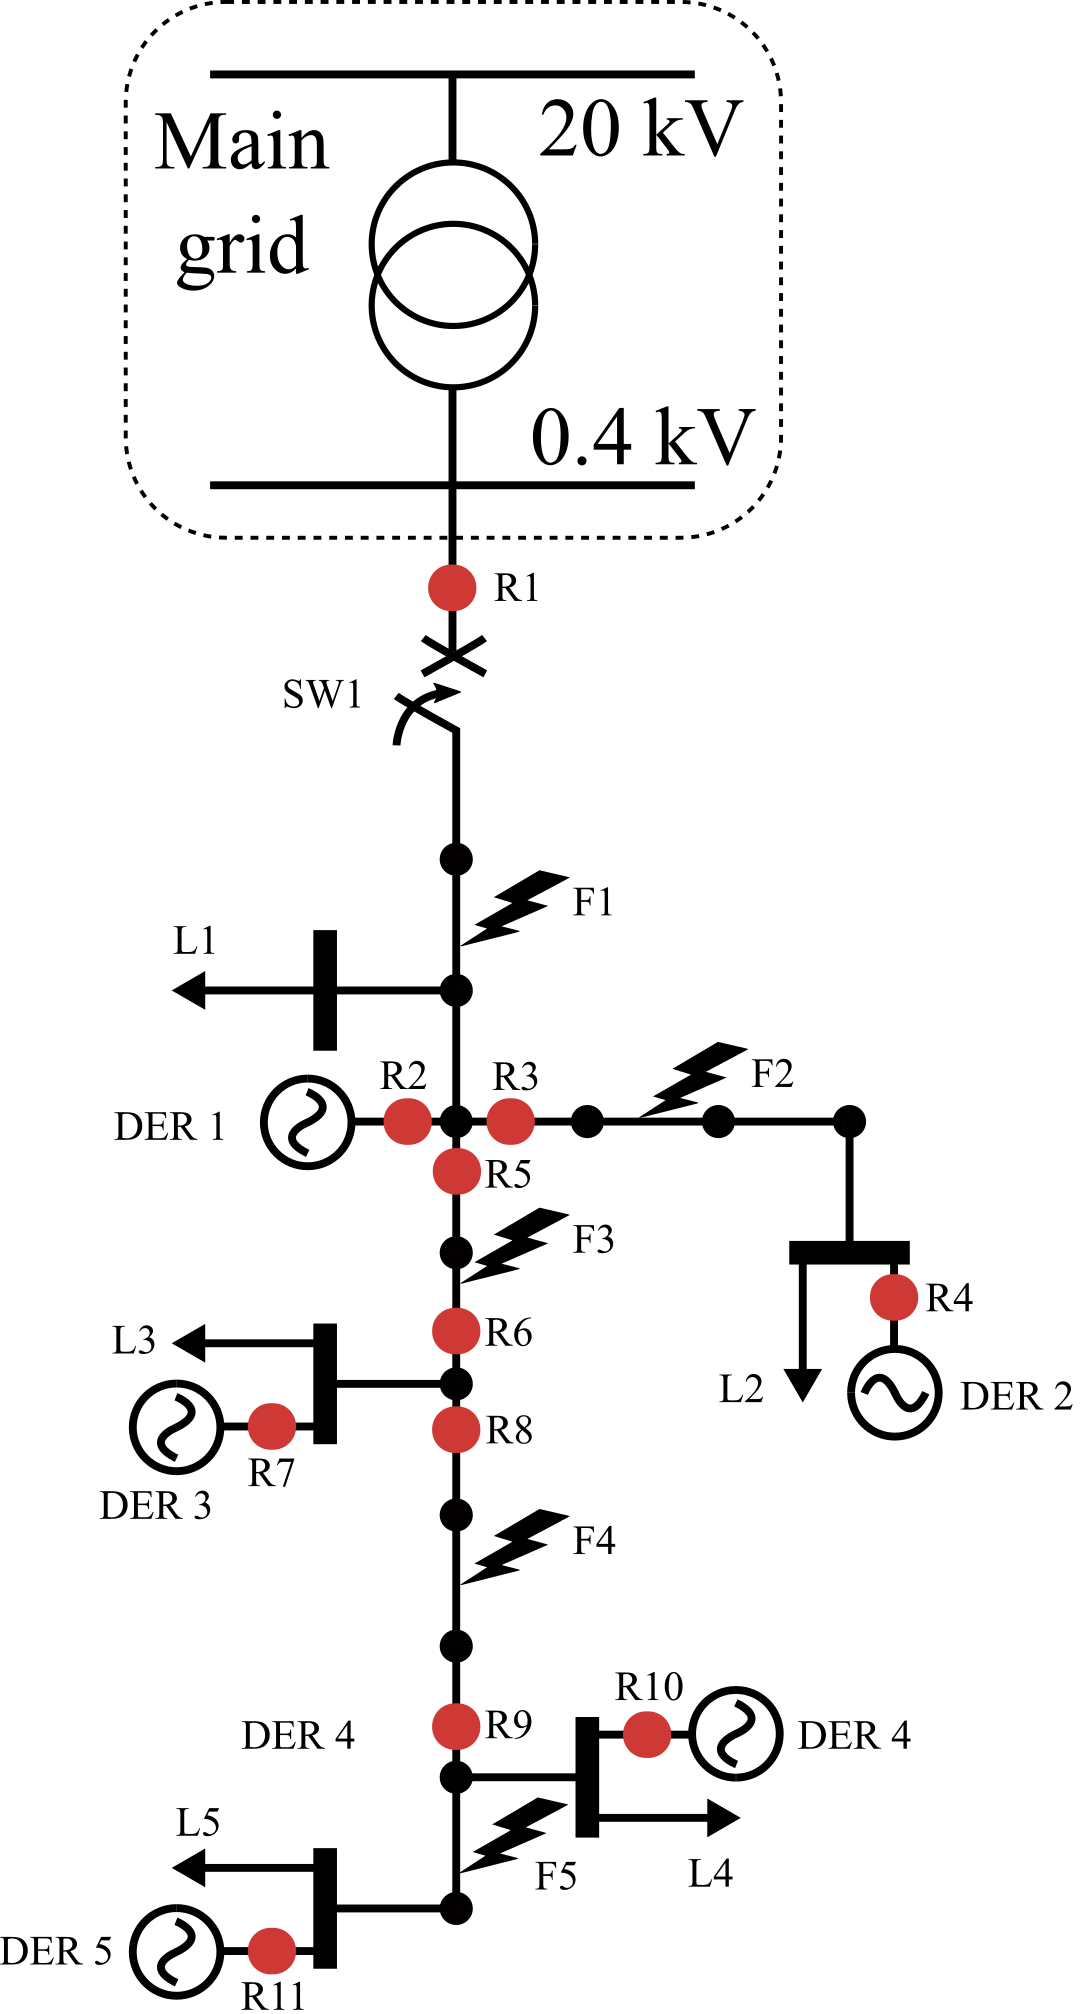

In [19]:
Image(filename = "cigre_microgrid.png", width = 400, height = 100)

## PSO Optimization

#### Grid connected

In [3]:
# Fault current at different point and relays from MATLAB

If_R1_P1 = 955.1
If_R2_P1 = 45.56
If_R4_P1 = 87.48
If_R6_P1 = 110.2
If_R7_P1 = 28.99
If_R9_P1 = 134.3


If_R4_P2 = 107.5
If_R3_P2 = 865.5
If_R2_P2 = 44.15
If_R1_P2 = 750.1
If_R6_P2 = 91.71

If_R5_P3 = 870.7
If_R4_P3 = 89.82
If_R2_P3 = 46.62
If_R1_P3 = 826.2
If_R6_P3 = 144.5
If_R7_P3 = 32.52
If_R9_P3 = 159.4


If_R8_P4 = 740.7
If_R7_P4 = 31.05
If_R5_P4 = 759.5
If_R9_P4 = 189.6
If_R10_P4 = 113.7
If_R11_P4 = 134


If_R11_P5 = 144.7
If_R10_P5 = 113.2
If_R8_P5 = 675.6
If_R7_P5 = 28.9
If_R5_P5 = 700.3

In [22]:
def banana_1(x):
    #x1 = x[0]  #R1
    #x2 = x[1]   
    #x3 = x[2]  #R2
    #x4 = x[3]
    #x5 = x[4]  #R3
    #x6 = x[5]
    #x7 = x[6]  #R4
    #x8 = x[7]
    #r5 = x[8]  #R5
    #r55 = x[9]
    #x11 = x[10]  #R6
    #x12 = x[11]
    #r7 = x[12]  #R7
    #r77 = x[13]
    #r8 = x[14]  #R8
    #r88 = x[15]
    #x17 = x[16]  #R9
    #x18 = x[17]
    #r10 = x[18]  #R10
    #r1010 = x[19]
    #r11 = x[20]  #R11
    #r1111 = x[21]
    
    r11   = x[0]
    r1111 = x[1]
    r10   = x[2]
    r1010 = x[3]
    r8    = x[4]
    r88   = x[5]
    r7    = x[6]
    r77   = x[7]
    r5    = x[8]
    r55   = x[9]
        
    #F1 = (alpha*x1)/(((If_R1_P1/CTR_R1)/x2)**beta - 1) + (alpha*x3)/(((If_R2_P1/CTR_R2)/x4)**beta - 1) \
       #+ (alpha*x7)/(((If_R4_P1/CTR_R4)/x8)**beta - 1) + (alpha*x11)/(((If_R6_P1/CTR_R6)/x12)**beta - 1)\
       #+ (alpha*r7)/(((If_R7_P1/CTR_R7)/r77)**beta - 1) + (alpha*x17)/(((If_R9_P1/CTR_R9)/x18)**beta - 1)
    
    #F2 = (alpha*x1)/(((If_R1_P2/CTR_R1)/x2)**beta - 1) + (alpha*x3)/(((If_R2_P2/CTR_R2)/x4)**beta - 1) \
       #+ (alpha*x7)/(((If_R4_P2/CTR_R4)/x8)**beta - 1) + (alpha*x11)/(((If_R6_P2/CTR_R6)/x12)**beta - 1)\
       #+ (alpha*x5)/(((If_R3_P2/CTR_R3)/x6)**beta - 1) 
    
    #F3 = (alpha*x1)/(((If_R1_P3/CTR_R1)/x2)**beta - 1) + (alpha*x3)/(((If_R2_P3/CTR_R2)/x4)**beta - 1) \
      # + (alpha*x7)/(((If_R4_P3/CTR_R4)/x8)**beta - 1) + (alpha*x11)/(((If_R6_P3/CTR_R6)/x12)**beta - 1)\
      # + (alpha*r7)/(((If_R7_P3/CTR_R7)/r77)**beta - 1) + (alpha*x17)/(((If_R9_P3/CTR_R9)/x18)**beta - 1)\
       #+ (alpha*r5)/(((If_R5_P3/CTR_R5)/r55)**beta - 1)
    
    #F4 = (alpha*x17)/(((If_R9_P4/CTR_R9)/x18)**beta - 1) + (alpha*r5)/(((If_R5_P4/CTR_R5)/r55)**beta - 1)\
     #  + (alpha*r7)/(((If_R7_P4/CTR_R7)/r77)**beta - 1) +(alpha*r8)/(((If_R8_P4/CTR_R8)/r88)**beta - 1)\
      # + (alpha*r10)/(((If_R10_P4/CTR_R10)/r1010)**beta - 1) + (alpha*r11)/(((If_R11_P4/CTR_R11)/r1111)**beta - 1) 
    
    
    F5 = (a*r11)/(((If_R11_P5/CTR_R11)/r1111)**beta - 1) + (a*r10)/(((If_R10_P5/CTR_R10)/r1010)**b - 1) + (a*r8)/(((If_R8_P5/CTR_R8)/r88)**b - 1) + (a*r7)/(((If_R7_P5/CTR_R7)/r77)**b - 1)   + (a*r5)/(((If_R5_P5/CTR_R5)/r55)**b - 1)

        
    #return F1+F2+F3+F4+F5
    #return F1+F2+F3+F4+F5
    #return F1+F2+F3+F4+F5
    #return F1+F2+F3+F4+F5
    return F5

#--------------Minimum operating constrains of each relay ----------------------------

def con_r1(x):
    x1 = x[0]
    x2 = x[1]
    return [((alpha*x1)/(((If_R1_P1/CTR_R1)/x2)**beta - 1)) - 0.1]

def con_r2(x):
    x3 = x[2]
    x4 = x[3]
    return [((alpha*x3)/(((If_R2_P2/CTR_R2)/x4)**beta - 1)) - 0.1]

def con_r3(x):
    x5 = x[4]
    x6 = x[5]
    return [((alpha*x5)/(((If_R3_P2/CTR_R3)/x6)**beta - 1)) - 0.1]

def con_r4(x):
    x7 = x[6]
    x8 = x[7]
    return [((alpha*x7)/(((If_R4_P2/CTR_R4)/x8)**beta - 1)) - 0.1]

def con_r5(x):
    r5 = x[8]
    r55 = x[9]
    return [((alpha*r5)/(((If_R5_P3/CTR_R5)/r55)**beta - 1)) - 0.1]

def con_r6(x):
    x11 = x[10]
    x12 = x[11]
    return [((alpha*x11)/(((If_R6_P3/CTR_R6)/x12)**beta - 1)) - 0.1]

def con_r7(x):
    r7 = x[6]
    r77 = x[7]
    return [((alpha*r7)/(((If_R7_P3/CTR_R7)/r77)**beta - 1)) - 0.1]

def con_r8(x):
    r8 = x[4]
    r88 = x[5]
    return [((alpha*r8)/(((If_R8_P4/CTR_R8)/r88)**beta - 1)) - 0.1]

def con_r9(x):
    x17 = x[16]
    x18 = x[17]
    return [((alpha*x17)/(((If_R9_P4/CTR_R9)/x18)**beta - 1)) - 0.1]

def con_r10(x):
    r10 = x[2]
    r1010 = x[3]
    return [((alpha*r10)/(((If_R10_P5/CTR_R10)/r1010)**beta - 1)) - 0.1]

def con_r11(x):
    r11 = x[0]
    r1111 = x[1]
    return [((alpha*r11)/(((If_R11_P5/CTR_R11)/r1111)**beta - 1)) - 0.1]
#----------------------------------------------------------------------
# ----------------Coordination constraints ----------------------------

# --------------Fault at point 1 ----------------- 

def coo_r76p1(x):
    x11 = x[10]
    x12 = x[11]
    r7 = x[12]
    r77 = x[13]
    return [((alpha*r7)/(((If_R7_P1/CTR_R7)/r77)**beta - 1)) - ((alpha*x11)/(((If_R6_P1/CTR_R6)/x12)**beta - 1)) - 0.3]

def coo_r96p1(x):
    x11 = x[10]
    x12 = x[11]
    x17 = x[16]
    x18 = x[17]
    return [((alpha*x17)/(((If_R9_P1/CTR_R9)/x18)**beta - 1)) - ((alpha*x11)/(((If_R6_P1/CTR_R6)/x12)**beta - 1)) - 0.3]

#-------------------- Fault at point 2 ----------------- 

def coo_r23(x):  # first back up and then primary
    x3 = x[2]
    x4 = x[3]
    x5 = x[4]
    x6 = x[5]
    return [((alpha*x3)/(((If_R2_P2/CTR_R2)/x4)**beta - 1)) - ((alpha*x5)/(((If_R3_P2/CTR_R3)/x6)**beta - 1)) - 0.3]


def coo_r13(x):  # first back up and then primary
    x1 = x[0]
    x2 = x[1]
    x5 = x[4]
    x6 = x[5]
    return [((alpha*x1)/(((If_R1_P2/CTR_R1)/x2)**beta - 1)) - ((alpha*x5)/(((If_R3_P2/CTR_R3)/x6)**beta - 1)) - 0.3]

def coo_r63(x):  # first back up and then primary
    x11 = x[10]
    x12 = x[11]
    x5 = x[4]
    x6 = x[5]
    return [((alpha*x11)/(((If_R6_P2/CTR_R6)/x12)**beta - 1)) - ((alpha*x5)/(((If_R3_P2/CTR_R3)/x6)**beta - 1)) - 0.3]

#--------------------- Fault at point 3 ----------------- 

def coo_r76p3(x):
    x11 = x[10]
    x12 = x[11]
    r7 = x[12]
    r77 = x[13]
    return [((alpha*r7)/(((If_R7_P3/CTR_R7)/r77)**beta - 1)) - ((alpha*x11)/(((If_R6_P3/CTR_R6)/x12)**beta - 1)) - 0.3]


def coo_r96p3(x):
    x11 = x[10]
    x12 = x[11]
    x17 = x[16]
    x18 = x[17]
    return [((alpha*x17)/(((If_R9_P3/CTR_R9)/x18)**beta - 1)) - ((alpha*x11)/(((If_R6_P3/CTR_R6)/x12)**beta - 1)) - 0.3]

def coo_r45(x):
    x7 = x[6]
    x8 = x[7]
    r5 = x[8]
    r55 = x[9]
    return [((alpha*x7)/(((If_R4_P3/CTR_R4)/x8)**beta - 1)) - ((alpha*r5)/(((If_R5_P3/CTR_R5)/r55)**beta - 1)) - 0.3]

def coo_r15(x):
    x1 = x[0]
    x2 = x[1]
    r5 = x[8]
    r55 = x[9]
    return [((alpha*x1)/(((If_R1_P3/CTR_R1)/x2)**beta - 1)) - ((alpha*r5)/(((If_R5_P3/CTR_R5)/r55)**beta - 1)) - 0.3]

def coo_r25(x):
    x3 = x[2]
    x4 = x[3]
    r5 = x[8]
    r55 = x[9]
    return [((alpha*x3)/(((If_R2_P3/CTR_R2)/x4)**beta - 1)) - ((alpha*r5)/(((If_R5_P3/CTR_R5)/r55)**beta - 1)) - 0.3]


#----------------- Fault at point 4 ----------------- 

def coo_r78p4(x):
    r8 = x[14]
    r88 = x[15]
    r7 = x[12]
    r77 = x[13]
    return [((alpha*r7)/(((If_R7_P4/CTR_R7)/r77)**beta - 1)) - ((alpha*r8)/(((If_R8_P4/CTR_R8)/r88)**beta - 1)) - 0.3]

def coo_r58p4(x):
    r5 = x[8]
    r55 = x[9]
    r8 = x[14]
    r88 = x[15]
    return [((alpha*r5)/(((If_R5_P4/CTR_R5)/r55)**beta - 1)) - ((alpha*r8)/(((If_R8_P4/CTR_R8)/r88)**beta - 1)) - 0.3]

def coo_r109(x):
    r10 = x[18]
    r1010 = x[19]
    x17 = x[16]
    x18 = x[17]
    return [((alpha*r10)/(((If_R10_P4/CTR_R10)/r1010)**beta - 1)) - ((alpha*x17)/(((If_R9_P4/CTR_R9)/x18)**beta - 1)) - 0.3]

def coo_r119(x):
    r11 = x[20]
    r1111 = x[21]
    x17 = x[16]
    x18 = x[17]
    return [((alpha*r11)/(((If_R11_P4/CTR_R11)/r1111)**beta - 1)) - ((alpha*x17)/(((If_R9_P4/CTR_R9)/x18)**beta - 1)) - 0.3]

#------------------ Fault at point 5 ----------------- 

def coo_r78p5(x):
    r8 = x[14]
    r88 = x[15]
    r7 = x[12]
    r77 = x[13]
    return [((alpha*r77)/(((If_R7_P5/CTR_R7)/r7)**beta - 1)) - ((alpha*r8)/(((If_R8_P5/CTR_R8)/r88)**beta - 1)) - 0.3]

def coo_r58p5(x):
    r5 = x[8]
    r55 = x[9]
    r8 = x[14]
    r88 = x[15]
    return [((alpha*r5)/(((If_R5_P5/CTR_R5)/r55)**beta - 1)) - ((alpha*r8)/(((If_R8_P5/CTR_R8)/r88)**beta - 1)) - 0.3]
#----------------------------------------------------------------------
#--------------------Variable bounds-----------------------------------

#coo_r76p1,coo_r96p1,coo_r23,coo_r13,coo_r63,coo_r76p3,coo_r96p3,coo_r45,coo_r15,coo_r25,coo_r78p4,coo_r58p4
#coo_r109,coo_r119,coo_r78p5,coo_r58p5


TMS_min = 0.025
TMS_max = 1.2

#lb = [TMS_min, R_min, TMS_min, R_min, TMS_min, R_min, TMS_min, R_min, TMS_min, R_min,TMS_min, R_min, TMS_min, R_min, TMS_min, R_min, TMS_min, R_min, TMS_min, R_min,TMS_min, R_min] # 22 variables total
#ub = [TMS_max, R_max, TMS_max, R_max, TMS_max, R_max, TMS_max, R_max, TMS_max, R_max,TMS_max, R_max, TMS_max, R_max, TMS_max, R_max, TMS_max, R_max, TMS_max, R_max,TMS_max, R_max]

lb = [TMS_min, R_min, TMS_min, R_min, TMS_min, R_min, TMS_min, R_min, TMS_min, R_min] # 22 variables total
ub = [TMS_max, R_max, TMS_max, R_max, TMS_max, R_max, TMS_max, R_max, TMS_max, R_max]

#----------------------------------------------------------------------

#----------------------------------------------------------------------
#---------------------------Run PSO------------------------------------

#xopt, fopt = pso(banana_1, lb, ub) #No constraints
#xopt, fopt = pso(banana_1, lb, ub, ieqcons=[con_r1,con_r2,con_r3,con_r4,con_r5,con_r6,con_r7,con_r8,con_r9,con_r10,con_r11])
#xopt, fopt = pso(banana_1, lb, ub, ieqcons=[con_r1,con_r2,con_r3,con_r4,con_r5,con_r6,con_r7,con_r8,con_r9,\
                                            #con_r10,con_r11,coo_r76p1])

xopt, fopt = pso(banana_1, lb, ub, ieqcons=[con_r5,con_r7,con_r8,con_r10,con_r11])

xopt, fopt

test_relays()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars


Stopping search: Swarm best position change less than 1e-08
R5 = 1.131968217161297
R7 = 32.47571991495417
R8 = 1.0228815079165814
R10 = 1.8740054594108178
R11 = 0.7594595938201499


#### Islanded

In [15]:
# Fault current at different point and relays from MATLAB

If_R7_P5 = 190.9
If_R9_P5 = 354.2

#### Grid connected-DER 2/4 OFF

In [18]:
# Fault current at different point and relays from MATLAB

If_R7_P5 = 696.1
If_R9_P5 = 700.8

In [19]:
def banana_1(x):
    x1 = x[0]  #R9
    x2 = x[1]   
    x3 = x[2]  #R7
    x4 = x[3]
 
    F5 = (alpha*x1)/(((If_R9_P5/CTR_R9)/x2)**beta - 1) + (alpha*x3)/(((If_R7_P5/CTR_R7)/x4)**beta - 1)
        
    return F5

#--------------Minimum operating constrains of each relay ----------------------------

def con_r9(x):
    x1 = x[0]
    x2 = x[1]
    return [((alpha*x1)/(((If_R9_P5/CTR_R9)/x2)**beta - 1)) - 0.1]

def con_r7(x):
    x3 = x[2]
    x4 = x[3]
    return [((alpha*x3)/(((If_R7_P5/CTR_R7)/x4)**beta - 1)) - 0.1]


#----------------------------------------------------------------------
# ----------------Coordination constraints ----------------------------

# --------------Fault at point 5 ----------------- 

def coo_r79(x):
    x1 = x[0]
    x2 = x[1]
    x3 = x[2]
    x4 = x[3]
    return [((alpha*x3)/(((If_R7_P5/CTR_R7)/x4)**beta - 1)) - ((alpha*x1)/(((If_R9_P5/CTR_R9)/x2)**beta - 1)) - 0.3]


#----------------------------------------------------------------------
#--------------------Variable bounds-----------------------------------

#coo_r76p1,coo_r96p1,coo_r23,coo_r13,coo_r63,coo_r76p3,coo_r96p3,coo_r45,coo_r15,coo_r25,coo_r78p4,coo_r58p4
#coo_r109,coo_r119,coo_r78p5,coo_r58p5

#-----------PS and TMS Bounds according to RELAY 751---------------

R_min = 0.05      # STEP 0.01
R_max = 4.80

TMS_min = 0.01    # STEP 0.01
TMS_max = 1.50


lb = [TMS_min, R_min, TMS_min, R_min] # 22 variables total
ub = [TMS_max, R_max, TMS_max, R_max]

#----------------------------------------------------------------------

#----------------------------------------------------------------------
#---------------------------Run PSO------------------------------------

xopt, fopt = pso(banana_1, lb, ub) #No constraints
#xopt, fopt = pso(banana_1, lb, ub, ieqcons=[con_r1,con_r2,con_r3,con_r4,con_r5,con_r6,con_r7,con_r8,con_r9,con_r10,con_r11])
#xopt, fopt = pso(banana_1, lb, ub, ieqcons=[con_r1,con_r2,con_r3,con_r4,con_r5,con_r6,con_r7,con_r8,con_r9,\
                                            #con_r10,con_r11,coo_r76p1])

xopt, fopt = pso(banana_1, lb, ub, ieqcons=[con_r9,con_r7,coo_r79])

xopt, fopt

test_relays()

Stopping search: maximum iterations reached --> 2500
Stopping search: Swarm best objective change less than 1e-08
R9 = 0.10000000615506294
R7 = 0.40000008220031913
R9 - R9 = 0.3000000760452562


In [13]:
Grid_connected = xopt
Grid_connected

array([0.04851248, 3.27808049, 0.14083919, 1.96186026])

In [17]:
Islanded = xopt
Islanded

array([0.09744965, 0.07396627, 0.05043136, 2.48721465])

In [20]:
DER24_OFF = xopt
DER24_OFF

array([0.09148495, 0.21160693, 0.16961024, 1.21694218])

In [21]:
def test_relays(): # Relay 1

    #TEST_R1 = (alpha*xopt[0])/(((If_R1_P1/CTR_R1)/xopt[1])**beta - 1) 

    # Relay 2

    #TEST_R2 = (alpha*xopt[2])/(((If_R2_P2/CTR_R2)/xopt[3])**beta - 1)

    # Relay 3

    #TEST_R3 = (alpha*xopt[4])/(((If_R3_P2/CTR_R3)/xopt[5])**beta - 1)

    # Relay 4

    #TEST_R4 = (alpha*xopt[6])/(((If_R4_P2/CTR_R4)/xopt[7])**beta - 1)

    # Relay 5

    TEST_R5 = (a*xopt[8])/(((If_R5_P3/CTR_R5)/xopt[9])**b - 1)

    # Relay 6

    #TEST_R6 = (alpha*xopt[10])/(((If_R6_P3/CTR_R6)/xopt[11])**beta - 1) 

    # Relay 7

    TEST_R7 = (a*xopt[6])/(((If_R7_P3/CTR_R7)/xopt[7])**b - 1)

    # Relay 8

    TEST_R8 = (a*xopt[4])/(((If_R8_P4/CTR_R8)/xopt[5])**b - 1)

    # Relay 9

    #TEST_R9 = (alpha*xopt[16])/(((If_R9_P4/CTR_R9)/xopt[17])**beta - 1)

    # Relay 10

    TEST_R10 = (a*xopt[2])/(((If_R10_P4/CTR_R10)/xopt[3])**b - 1)
    
    # Relay 11
    
    TEST_R11 = (a*xopt[0])/(((If_R11_P4/CTR_R11)/xopt[1])**b - 1)


    #tr12 = ((alpha*xopt[0])/(((If_R1_P2/CTR_R1)/xopt[1])**beta - 1)) - ((alpha*xopt[2])/(((If_R2_P2/CTR_R2)/xopt[3])**beta- 1))
    #tr23 = ((alpha*xopt[2])/(((If_R2_P3/CTR_R2)/xopt[3])**beta - 1)) - ((alpha*xopt[4])/(((If_R3_P3/CTR_R3)/xopt[5])**beta- 1))
    #tr34 = ((alpha*xopt[4])/(((If_R3_P4/CTR_R3)/xopt[5])**beta - 1)) - ((alpha*xopt[6])/(((If_R4_P4/CTR_R4)/xopt[7])**beta- 1))
    #tr45 = ((alpha*xopt[6])/(((If_R4_P5/CTR_R4)/xopt[7])**beta - 1)) - ((alpha*xopt[8])/(((If_R5_P5/CTR_R5)/xopt[9])**beta - 1))                                                         

    #print('R1 = {:}'.format(TEST_R1))
    #print('R2 = {:}'.format(TEST_R2))
    #print('R3 = {:}'.format(TEST_R3))
    #print('R4 = {:}'.format(TEST_R4))
    print('R5 = {:}'.format(TEST_R5))
    #print('R6 = {:}'.format(TEST_R6))
    print('R7 = {:}'.format(TEST_R7))
    print('R8 = {:}'.format(TEST_R8))
    #print('R9 = {:}'.format(TEST_R9))
    print('R10 = {:}'.format(TEST_R10))
    print('R11 = {:}'.format(TEST_R11))

    #print('R1 - R2 = {:}'.format(tr12))
    #print('R2 - R3 = {:}'.format(tr23))
    #print('R3 - R4 = {:}'.format(tr34))
    #print('R4 - R5 = {:}'.format(tr45))
    return



### Example of PSO use

In [3]:

def banana(x):
    x1 = x[0]
    x2 = x[1]
    return (80*x1)/(((1000/300)/4)**2 - 1) + (80*x2)/(((900/300)/4)**2 - 1)

def con(x):
    x1 = x[0]
    x2 = x[1]
    return [-(x1 + 0.25)**2 + 0.75*x2]

def con1(x):
    x1 = x[0]
    x2 = x[1]
    return [-(x1 + 0.125)**2 + 0.75*x2]

lb = [-3, -1]
ub = [2, 6]

xopt, fopt = pso(banana, lb, ub, ieqcons=[con,con1])
xopt,fopt

Stopping search: Swarm best objective change less than 1e-08


(array([0.50024548, 0.75049108]), 4.500000171311138)

In [6]:
def tomato(x):
    x1 = x[0]
    x2 = x[1]
    return (80*x1)/(((1000/300)/4)**2 - 1) + (80*x2)/(((900/300)/4)**2 - 1)
def con(x):
    x1 = x[0]
    x2 = x[1]
    return [(80*x1)/(((1000/300)/4)**2 - 1)-(80*x2)/(((1000/300)/4)**2 - 1)-0.3]
lb = [0.01,0.01]
ub = [1.5,1.5]

xopt, fopt = pso(tomato, lb, ub, ieqcons=[con])
xopt,fopt

Stopping search: Swarm best position change less than 1e-08


(array([1.49885415, 1.5       ]), -666.7129833472303)

In [2]:
from functools import partial
import numpy as np

def _obj_wrapper(func, args, kwargs, x):
    return func(x, *args, **kwargs)

def _is_feasible_wrapper(func, x):
    return np.all(func(x)>=0)

def _cons_none_wrapper(x):
    return np.array([0])

def _cons_ieqcons_wrapper(ieqcons, args, kwargs, x):
    return np.array([y(x, *args, **kwargs) for y in ieqcons])

def _cons_f_ieqcons_wrapper(f_ieqcons, args, kwargs, x):
    return np.array(f_ieqcons(x, *args, **kwargs))
    
def pso(func, lb, ub, ieqcons=[], f_ieqcons=None, args=(), kwargs={}, 
        swarmsize=1000, omega=0.5, phip=0.5, phig=0.5, maxiter=2500, 
        minstep=1e-8, minfunc=1e-8, debug=False, processes=1,
        particle_output=False):
    """
    Perform a particle swarm optimization (PSO)
   
    Parameters
    ==========
    func : function
        The function to be minimized
    lb : array
        The lower bounds of the design variable(s)
    ub : array
        The upper bounds of the design variable(s)
   
    Optional
    ========
    ieqcons : list
        A list of functions of length n such that ieqcons[j](x,*args) >= 0.0 in 
        a successfully optimized problem (Default: [])
    f_ieqcons : function
        Returns a 1-D array in which each element must be greater or equal 
        to 0.0 in a successfully optimized problem. If f_ieqcons is specified, 
        ieqcons is ignored (Default: None)
    args : tuple
        Additional arguments passed to objective and constraint functions
        (Default: empty tuple)
    kwargs : dict
        Additional keyword arguments passed to objective and constraint 
        functions (Default: empty dict)
    swarmsize : int
        The number of particles in the swarm (Default: 100)
    omega : scalar
        Particle velocity scaling factor (Default: 0.5)
    phip : scalar
        Scaling factor to search away from the particle's best known position
        (Default: 0.5)
    phig : scalar
        Scaling factor to search away from the swarm's best known position
        (Default: 0.5)
    maxiter : int
        The maximum number of iterations for the swarm to search (Default: 100)
    minstep : scalar
        The minimum stepsize of swarm's best position before the search
        terminates (Default: 1e-8)
    minfunc : scalar
        The minimum change of swarm's best objective value before the search
        terminates (Default: 1e-8)
    debug : boolean
        If True, progress statements will be displayed every iteration
        (Default: False)
    processes : int
        The number of processes to use to evaluate objective function and 
        constraints (default: 1)
    particle_output : boolean
        Whether to include the best per-particle position and the objective
        values at those.
   
    Returns
    =======
    g : array
        The swarm's best known position (optimal design)
    f : scalar
        The objective value at ``g``
    p : array
        The best known position per particle
    pf: arrray
        The objective values at each position in p
   
    """
   
    assert len(lb)==len(ub), 'Lower- and upper-bounds must be the same length'
    assert hasattr(func, '__call__'), 'Invalid function handle'
    lb = np.array(lb)
    ub = np.array(ub)
    assert np.all(ub>lb), 'All upper-bound values must be greater than lower-bound values'
   
    vhigh = np.abs(ub - lb)
    vlow = -vhigh

    # Initialize objective function
    obj = partial(_obj_wrapper, func, args, kwargs)
    
    # Check for constraint function(s) #########################################
    if f_ieqcons is None:
        if not len(ieqcons):
            if debug:
                print('No constraints given.')
            cons = _cons_none_wrapper
        else:
            if debug:
                print('Converting ieqcons to a single constraint function')
            cons = partial(_cons_ieqcons_wrapper, ieqcons, args, kwargs)
    else:
        if debug:
            print('Single constraint function given in f_ieqcons')
        cons = partial(_cons_f_ieqcons_wrapper, f_ieqcons, args, kwargs)
    is_feasible = partial(_is_feasible_wrapper, cons)

    # Initialize the multiprocessing module if necessary
    if processes > 1:
        import multiprocessing
        mp_pool = multiprocessing.Pool(processes)
        
    # Initialize the particle swarm ############################################
    S = swarmsize
    D = len(lb)  # the number of dimensions each particle has
    x = np.random.rand(S, D)  # particle positions
    v = np.zeros_like(x)  # particle velocities
    p = np.zeros_like(x)  # best particle positions
    fx = np.zeros(S)  # current particle function values
    fs = np.zeros(S, dtype=bool)  # feasibility of each particle
    fp = np.ones(S)*np.inf  # best particle function values
    g = []  # best swarm position
    fg = np.inf  # best swarm position starting value
    
    # Initialize the particle's position
    x = lb + x*(ub - lb)

    # Calculate objective and constraints for each particle
    if processes > 1:
        fx = np.array(mp_pool.map(obj, x))
        fs = np.array(mp_pool.map(is_feasible, x))
    else:
        for i in range(S):
            fx[i] = obj(x[i, :])
            fs[i] = is_feasible(x[i, :])
       
    # Store particle's best position (if constraints are satisfied)
    i_update = np.logical_and((fx < fp), fs)
    p[i_update, :] = x[i_update, :].copy()
    fp[i_update] = fx[i_update]

    # Update swarm's best position
    i_min = np.argmin(fp)
    if fp[i_min] < fg:
        fg = fp[i_min]
        g = p[i_min, :].copy()
    else:
        # At the start, there may not be any feasible starting point, so just
        # give it a temporary "best" point since it's likely to change
        g = x[0, :].copy()
       
    # Initialize the particle's velocity
    v = vlow + np.random.rand(S, D)*(vhigh - vlow)
       
    # Iterate until termination criterion met ##################################
    it = 1
    while it <= maxiter:
        rp = np.random.uniform(size=(S, D))
        rg = np.random.uniform(size=(S, D))

        # Update the particles velocities
        v = omega*v + phip*rp*(p - x) + phig*rg*(g - x)
        # Update the particles' positions
        x = x + v
        # Correct for bound violations
        maskl = x < lb
        masku = x > ub
        x = x*(~np.logical_or(maskl, masku)) + lb*maskl + ub*masku

        # Update objectives and constraints
        if processes > 1:
            fx = np.array(mp_pool.map(obj, x))
            fs = np.array(mp_pool.map(is_feasible, x))
        else:
            for i in range(S):
                fx[i] = obj(x[i, :])
                fs[i] = is_feasible(x[i, :])

        # Store particle's best position (if constraints are satisfied)
        i_update = np.logical_and((fx < fp), fs)
        p[i_update, :] = x[i_update, :].copy()
        fp[i_update] = fx[i_update]

        # Compare swarm's best position with global best position
        i_min = np.argmin(fp)
        if fp[i_min] < fg:
            if debug:
                print('New best for swarm at iteration {:}: {:} {:}'\
                    .format(it, p[i_min, :], fp[i_min]))

            p_min = p[i_min, :].copy()
            stepsize = np.sqrt(np.sum((g - p_min)**2))

            if np.abs(fg - fp[i_min]) <= minfunc:
                print('Stopping search: Swarm best objective change less than {:}'\
                    .format(minfunc))
                if particle_output:
                    return p_min, fp[i_min], p, fp
                else:
                    return p_min, fp[i_min]
            elif stepsize <= minstep:
                print('Stopping search: Swarm best position change less than {:}'\
                    .format(minstep))
                if particle_output:
                    return p_min, fp[i_min], p, fp
                else:
                    return p_min, fp[i_min]
            else:
                g = p_min.copy()
                fg = fp[i_min]

        if debug:
            print('Best after iteration {:}: {:} {:}'.format(it, g, fg))
        it += 1

    print('Stopping search: maximum iterations reached --> {:}'.format(maxiter))
    
    if not is_feasible(g):
        print("However, the optimization couldn't find a feasible design. Sorry")
    if particle_output:
        return g, fg, p, fp
    else:
        return g, fg

### Second optimization algorithm